# Compressão de PDF's

**Big data & Astroinformática**

**Professor:** Clécio de Bom

**Aluno:** Pedro Riba Mello

Neste notebook estudaremos duas formas diferentes de comprimir uma função densidade de probabilidade (PDF) - a sigla está em inglês. A PDF utilizada será de redshift fotométrico.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import ast #convert str representation of list to list of floats
import pickle

from scipy.stats import norm

from sklearn.decomposition import PCA
import os

import random
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense
import keras

In [3]:
z_photo_real = pd.read_csv('test_data_legacy_toDoc.csv')
zpdf_0 = z_photo_real['PDFs']

zmin = 0.0
zmax = 0.6
nbins = 200
bins = np.linspace(zmin, zmax, nbins)

#converte a representação de str de listas em uma lista de floats  
zpdfs = np.array(list(map(lambda lst : ast.literal_eval(lst), zpdf_0)))
zspec = z_photo_real['zspec'].to_numpy()

In [4]:
PDF=zpdfs #escolhendo qual PDF iremos comprimir - agora vamos comprimir a pdf fotométrica real

Para entender porque a compressão de PDF's é importante considere, por exemplo, que o Dark Energy Survey observa 300 milhões de estrelas, ou seja, $N_{DES}= 3\times 10^8$ estrelas. Em uma estimativa bem rudimentar, se a PDF de cada estrela tivesse aproximadamente o mesmo tamanho de uma das PDF's utilizadas, teríamos 843 GB apenas de redshift fotométrico de galáxias.

>>https://www.darkenergysurvey.org/the-des-project/survey-and-operations/

Sendo assim, é desejável que achemos uma forma de comprimir os dados e gastar menos espaço. Aqui veremos duas formas distintas:

1. Principal Component Analysis (PCA)
2. Auto-encoder

Para comparar a qualidade de compressão dos dados utilizaremos duas métricas, a Divergência de Kullback-Leibler e o critério de informação Bayesiana.

In [ ]:
(57.483/PDF.shape[0])*3*10**8/10**3

In [ ]:
PDF.shape

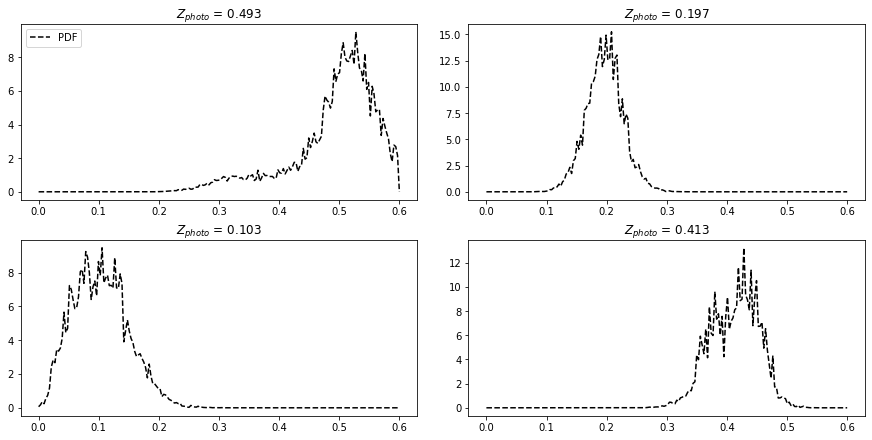

In [5]:
#função para plotar gráficos que será utilizada posteriormente
def plot_data(data, label_data = 'PDF'):
    ver=2
    hor=2

    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

    k=0
    for v in range(ver):
        for h in range(hor):
            idx = random.sample(range(data.shape[0]), 1)[0]
            ax = fig.add_subplot(gs[v, h])

            ax.plot(bins, data[idx].squeeze(),'--',  alpha=1, c='black',
                    label=label_data)

            ax.set_title("$Z_{photo}$ = "+str(round(np.average(bins, weights = data[idx]),3)))
            if k==0: plt.legend(loc='best')
            k+=1
            
plot_data(PDF)

## Aplicando PCA nos dados

> Vamos começar entendendo a informação contida na compressão. Para isso, vamos calcular 200 componentes de PCA, assim teríamos uma reconstrução perfeita dos dados:

In [6]:
n_components=200 #número de componentes PCA que serão utilizadas
# n_components=200
save_pca = False #aqui definimos se as informações do PCA serão salvas para utilizar os dados em outro programa.

pca=PCA(n_components=n_components) #definindo o objeto pca

PDF=zpdfs #escolhendo qual PDF iremos comprimir - vamos comprimir a pdf fotométrica real
pca.fit(PDF)

compressed=pca.transform(PDF) #aqui comprimimos a PDF
decomp=pca.inverse_transform(compressed) #aqui temos a PDF após a compressão.

eigenvalues=pca.singular_values_ #Os autovalores são as variâncias em cada componente PC
tot=np.sum(eigenvalues)

var_exp = [(i / tot) for i in eigenvalues]
cum_var_exp=np.cumsum(var_exp) #aqui temos a soma cumulativa dos auto-valores, a explained variance

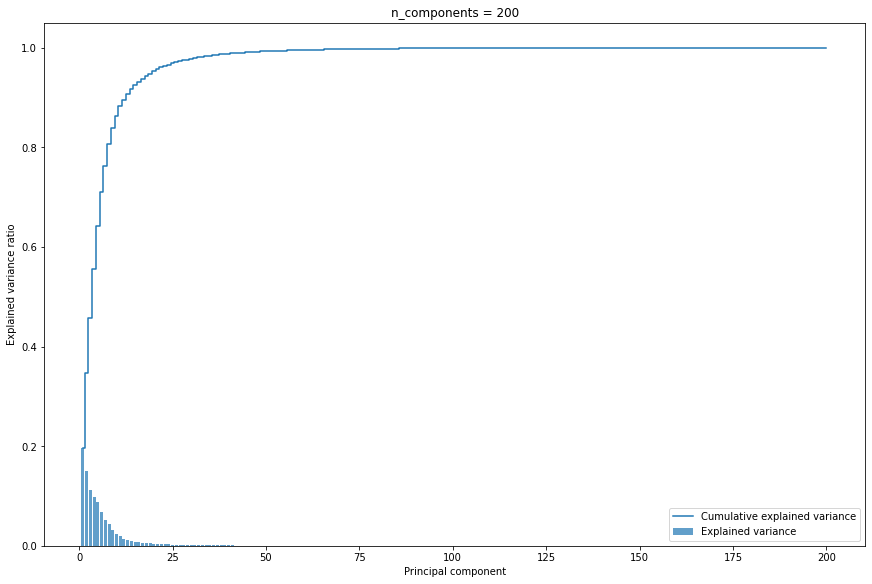

Informação contida nas primeiras 20 PC =  95.3 %
Informação contida nas primeiras 50 =  99.3 %


In [7]:
#Plotando a explained variance
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
nplot=n_components #number of principal components to plot
plt.bar(range(1,nplot+1),var_exp[:nplot],alpha=0.7,align='center',label='Explained variance')
plt.step(range(1,nplot+1),cum_var_exp[:nplot],where='mid',label='Cumulative explained variance')
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component")
plt.title("n_components = "+str(n_components))
plt.legend(loc='best')
plt.show()

n_PC = 20
print('Informação contida nas primeiras {} PC = '.format(n_PC), round((1-np.sum(var_exp[n_PC:]))*100,1), '%')
print('Informação contida nas primeiras 50 = ', round((1-np.sum(var_exp[50:]))*100,1), '%')

Agora vamos comprimir os dados de fato. Para isso, vamos manter apenas 20 componentes PCA, pois como vimos anteriormente, com 20 componentes mantemos $95.3\%$ da informação de todas as PDF's, onde "informação" é usado como sinônimo de variância.

In [24]:
n_components=20 #número de componentes PCA que serão utilizadas
save_pca = False #aqui definimos se as informações do PCA serão salvas para utilizar os dados em outro programa.

pca=PCA(n_components=n_components) #definindo o objeto pca

PDF=zpdfs #escolhendo qual PDF iremos comprimir - agora vamos comprimir a pdf fotométrica real
pca.fit(PDF)

compressed=pca.transform(PDF) #aqui comprimimos a PDF
decomp=pca.inverse_transform(compressed) #aqui temos a PDF após a compressão.

eigenvalues=pca.singular_values_
tot=np.sum(eigenvalues)

var_exp = [(i / tot) for i in eigenvalues]
cum_var_exp=np.cumsum(var_exp)

print("Shape of original data: ",np.shape(PDF))
print("Shape of compressed data: ",np.shape(compressed))

#Salvando informações da transformação PCA;
if save_pca:
    #salvando PDF comprimida
    df = pd.DataFrame(compressed)
    df.to_csv('PCA_compressed.csv')
    #salvando pca para realizar a descompressão
    with open('pca.pkl', 'wb') as pickle_file:
            pickle.dump(pca, pickle_file)
    print("PCA saved to disk")

#A função abaixo pode ser usada para abrir o objeto pca em outro código.
def import_pca(name = 'pca.pkl'):
    with open(name, 'rb') as pickle_file:
        pca = pickle.load(pickle_file)

Shape of original data:  (20434, 200)
Shape of compressed data:  (20434, 20)


Percentage of variance on PC1 =  20.5799671325609 %
Percentage of variance on PC2 =  15.730580765012112 %
Percentage of variance on PC3 =  11.687400239666532 %
Percentage of variance on sum(PC>10) =  9.357638534056555 %


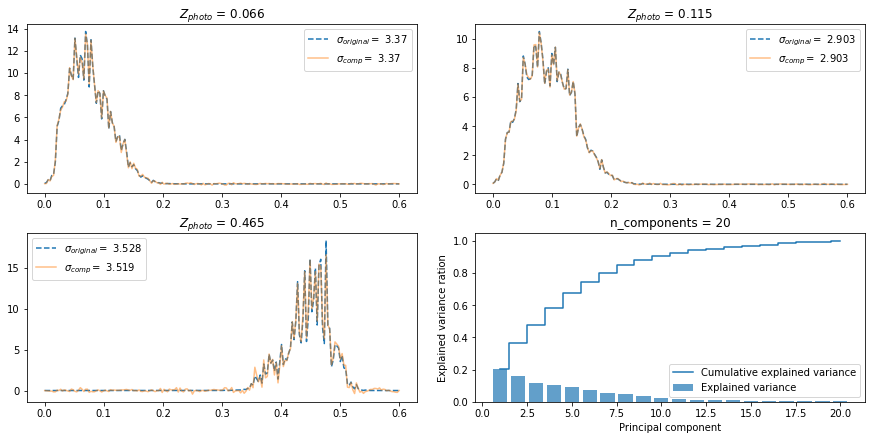

In [20]:
print("Percentage of variance on PC1 = ", 100*var_exp[0], "%")
print("Percentage of variance on PC2 = ", 100*var_exp[1], "%")
print("Percentage of variance on PC3 = ", 100*var_exp[2], "%")
explained_max = int(n_components/2)
print("Percentage of variance on sum(PC>{}) = ".format(explained_max),np.sum(var_exp[explained_max:])*100, "%")


ver=2
hor=2

fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

k=0
for v in range(ver):
    for h in range(hor):
        i=1000*k # para pegar redshifts espaçados na lista
        if k<ver*hor-1:
            ax = fig.add_subplot(gs[v, h])

            ax.plot(bins, PDF[i],'--',  alpha=1, label="$\sigma_{original} = $ "+str(round(np.sqrt(PDF[i].var(ddof=1)),3)))
            ax.plot(bins, decomp[i],'-', alpha=0.5, label="$\sigma_{comp} = $ "+str(round(np.sqrt(decomp[i].var(ddof=1)),3)))

            ax.set_title("$Z_{photo}$ = "+str(round(zspec[i],3)))
            plt.legend(loc='best')
            k+=1
        else:
#             nplot=n_components
            nplot=n_components #number of principal components to plot
            ax = fig.add_subplot(gs[v, h])
            ax.bar(range(1,nplot+1),var_exp[:nplot],alpha=0.7,align='center',label='Explained variance')
            ax.step(range(1,nplot+1),cum_var_exp[:nplot],where='mid',label='Cumulative explained variance')
            ax.set_ylabel("Explained variance ration")
            ax.set_xlabel("Principal component")
            ax.set_title("n_components = "+str(n_components))
            plt.legend(loc='best')

Os três primeiros gráficos mostram a distribuição original (em azul) e a distribuição após ser comprimida (em laranja) para redshifts distintos. O quarto gráfico mostra a "explained_variance" dos dados, i.e. a variância total dos dados conforme o número de componentes. 


O arquivo comprimido possui ~7.9 Mb e o arquivo ".pkl", onde está salvo o modelo PCA, necessário para descomprimir os dados possui 34 Kb. Sendo assim, reduzimos o tamanho total de 57.483 Kb para 7.889 Kb. Ou seja, aproximadamente 13.72% do tamanho original do arquivo. 


Caso isso fosse aplicado aos dados do DES, como vimos no começo do nb, reduziríamos o tamanho de ~843 GB para ~115 GB.

>Nos gráficos abaixo veja como a compressão fica visivelmente melhor conforme aumentamos o número de componentes PCA: 

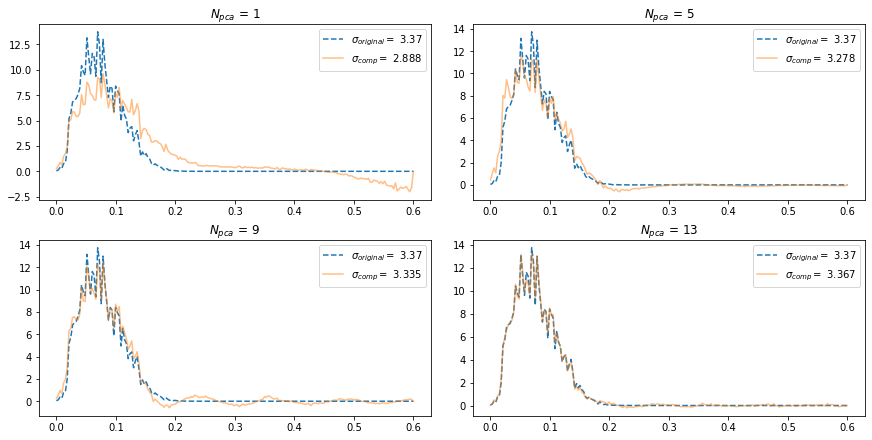

In [21]:
ver=2
hor=2

fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

PDF=zpdfs
i=0
for v in range(ver):
    for h in range(hor):
        tmp = 4*i + 1
        pc=PCA(n_components=tmp)
        compressed=pc.fit_transform(PDF)
        decomp=pc.inverse_transform(compressed)
        
        ax = fig.add_subplot(gs[v, h])

        ax.plot(bins, PDF[0],'--',  alpha=1, label="$\sigma_{original} = $ "+str(round(np.sqrt(PDF[0].var(ddof=1)),3)))
        ax.plot(bins, decomp[0],'-', alpha=0.5, label="$\sigma_{comp} = $ "+str(round(np.sqrt(decomp[0].var(ddof=1)),3)))

        ax.set_title("$N_{pca}$ = "+str(tmp))
        plt.legend(loc='best')
        i+=1

## Como avaliar a qualidade de compressão da PCA?

Para responder essa pergunta vamos analisar o problema por três critérios diferentes. O primeiro já vimos, a "explained_variance" das componentes principais nos dizem qual a variância de cada componente. Além disso, podemos avaliar a qualidade de compressão de acordo com o "Bayesian Criterion Information (BIC)" e também de acordo com a divergência de Kullback-Leibler. 

### Bayesian Criterion information

O critério de informação bayesiana (BIC) é definido pela seguinte fórmula:

$$
\text{BIC}=k\cdot \ln(n)-2\ln(\hat{L})
$$

Onde k é o número de parâmetros no modelo, n é o número de pontos de dados ou (sample size) e $\hat{L}$ é o estimador de likelihood máxima (MLE).

No presente caso, como o interesse é calcular a "eficiência" da compressão, n é o tamanho da amostra de redshifts fotométricos, k é o número de dimensões - originais e comprimidas - e $\hat{L}$ é a soma de todos os MLE.

In [35]:
#implementando a função p/ calcular o BIC
def bic(k,n,L): 
    return k*np.log(n)-2*np.log(L)

nmax=len(bins)
nmax=50
bic_list=np.array([],dtype=(np.float64,3))

for nc in range(1,nmax+1):
    pc=PCA(n_components=nc) #define o PCA com nc componentes
    compressed=pc.fit_transform(PDF)#calcula a compressão dos dados 
    decomp=pc.inverse_transform(compressed) #obtém a representação dos dados após descompressão
    decomp=np.where(decomp > 0, decomp , 1e-100) #filtra valores menores que zero
        
    #Parâmetros para a função bic(args_)
    nori, kori = np.shape(PDF)
    ncomp, kcomp = np.shape(decomp)
    Lcomp = np.sum(list(map(max,decomp)))
    Lori = np.sum(list(map(max,PDF)))
    
    bic_comp=bic(kcomp,ncomp,Lcomp) #BIC dos dados comprimidos 
    bic_ori=bic(kori,nori,Lori)
    
    if (nc%10 == 0 or nc==1) : print('Npca = ',nc,'\t|\t',"frac = ",(bic_comp/bic_ori-1)*100,'%')
        
    stack=np.array([nc,bic_ori,bic_comp])
    bic_list=np.vstack((bic_list,stack))

Npca =  1 	|	 frac =  0.06676202355531125 %
Npca =  10 	|	 frac =  0.0031088867807671505 %
Npca =  20 	|	 frac =  0.0004054217591642484 %
Npca =  30 	|	 frac =  3.9421418907004124e-05 %
Npca =  40 	|	 frac =  6.596704316130797e-06 %
Npca =  50 	|	 frac =  9.537015510652225e-06 %


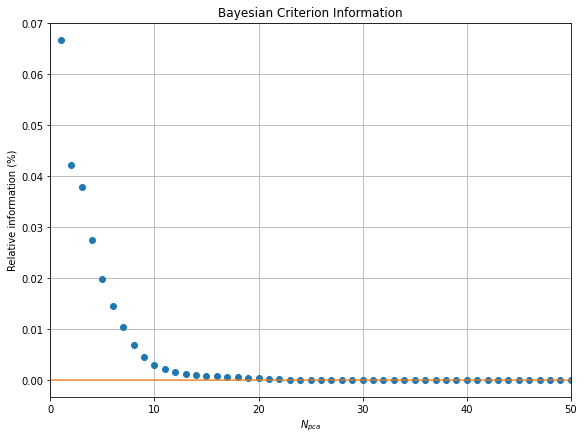

In [80]:
df=pd.DataFrame(bic_list, columns=["Npca","BIC_ori","BIC_comp"])

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.plot(df['Npca'],(df['BIC_comp']/df['BIC_ori']-1)*100,'o')#, label="$BIC ratio$")
ax.plot(np.arange(-1,nmax+4,1),np.zeros(nmax+5), alpha=.8)

ax.set_xlabel("$N_{pca}$")

ax.set_ylabel("Relative information (%)")

ax.set_xlim(0,nmax)
ax.grid()
ax.set_title("Bayesian Criterion Information")

plt.show()
plt.close()

O gráfico acima nos mostra o erro relativo entre o BIC da distribuição comprimida e da distribuição original, ou seja:
$$
\frac{BIC_{comp}-BIC_{orig}}{BIC_{orig}} \cdot 100 \%
$$

Esperamos que $BIC_{comp}>BIC_{orig}$. Quanto menor o valor da fração no gráfico melhor o resultado da compressão. 

Vemos que com 30 componentes, o BIC relativo é quase nulo.

### Divergência de Kullback-Leibler

A divergência de kullback leibler é definida como:

$$
D(p||q)=\int^{\infty}_{-\infty}p(x) \log[p(x)/q(x)] dx
$$

Ela é nula quando as distribuições são iguais.

Abaixo, a implementamos como um somatório:

$$
D(p||q)\simeq \sum_{i=1}^{nbins}p(x_i) \log[p(x_i)/q(x_i)]
$$

In [90]:
def kbl_divergence(p, q, x):
    '''
    Implements the Kullback-Leibler divergence D(p|q);
    Parameters:
    np.array, p    :   N-dimensional array containing the PDF p(x)      
    np.array, q    :   N-dimensional array containing the PDF q(x) 
    np.array, x    :   N-dimensional array containing the x values os p and q.     

    Returns de Kullback-Leibler divergence D(p|q)

    Dependencies: numpy
    '''
    dx=x[1]-x[0]
    
    pnz = np.where(p>0, p, 1e-100)
    qnz = np.where(q>0, q, 1e-100)
    
    return (np.sum(pnz*np.log(pnz))-np.sum(pnz*np.log(qnz)))*dx

In [95]:
#calcula o dataset comprimido para nmax componentes diferentes.
nmax=len(bins)
nmax=50
kbl_list=np.array([],dtype=(np.float64,2))
for nc in range(1,nmax+1):
    pc=PCA(n_components=nc)
    compressed=pc.fit_transform(PDF)
    decomp=pc.inverse_transform(compressed)
    
    div=kbl_divergence(decomp,PDF,bins) #calcula a divergência de KBL entre os dados antes e após a compressão
    
    stack=np.array([nc,div])
    kbl_list=np.vstack((kbl_list,stack))
    
    if (nc%10 == 0 or nc==1) : print('Npca = ',nc,'\t|\t',"Dkbl = ", round(div,3), 'nants')
#     print('Npca = ',nc,'\t|\t',"Dkbl = ", round(div,3), 'nants')

Npca =  1 	|	 Dkbl =  104191.317 nants
Npca =  10 	|	 Dkbl =  10198.645 nants
Npca =  20 	|	 Dkbl =  2524.78 nants
Npca =  30 	|	 Dkbl =  935.869 nants
Npca =  40 	|	 Dkbl =  373.685 nants
Npca =  50 	|	 Dkbl =  183.426 nants


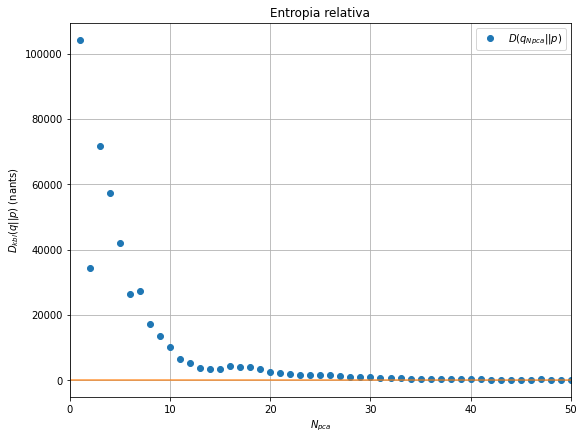

In [96]:
df=pd.DataFrame(kbl_list, columns=["Npca","Dkbl"])

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.plot(df['Npca'],df['Dkbl'],'o', label="$D(q_{Npca}||p)$")
ax.plot(np.arange(-1,nmax+4,1),np.zeros(nmax+5), alpha=.8)

ax.set_xlabel("$N_{pca}$")
ax.set_ylabel("$D_{kbl}(q||p)$ (nants)")

ax.set_xlim(0,nmax)
ax.grid()
ax.set_title("Entropia relativa")
plt.legend(loc='best')
plt.show()
plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.plot(kbl_list[:,0],np.gradient(kbl_list[:,1]),'--', label="$\Delta (D(q_{Npca}||p))$")
ax.plot(np.arange(-1,nmax+4,1),np.zeros(nmax+5), alpha=.8)

ax.set_xlabel("$N_{pca}$")
ax.set_ylabel("$\Delta D_{kbl}$")

ax.set_xlim(0,nmax)
# ax.set_ylim(-3000,3000)
ax.grid()
ax.set_title("Variação da entropia relativa")
plt.legend(loc='best')

plt.show()
plt.close()

Vemos que a entropia relativa (divergência de Kullback-Leibler) converge para 0, porém, a convergência é mais lenta que a convergência do BIC.

A entropia relativa poderia vir a ser utilizada como parâmetro para avaliar a qualidade de compressão caso os dados fossem mais suáves. Como os dados possuem muitos picos acentuados, a entropia relativa entre a reconstrução e os dados originais será muito grande!

Caso possuamos dados mais suáves, poderíamos comparar a entropia relativa da reconstrução com uma medida conhecida, com por exemplo, a entropia relativa entre duas distribuições deslocadas de $1\sigma$ e a partir daí, calcular quão diferente é o aceitável para nossos dados.

## Auto-encoder

Agora vamos construir um auto-encoder. Um auto-enconder é uma rede neural composta por três partes, um encoder um núcleo e um decoder:

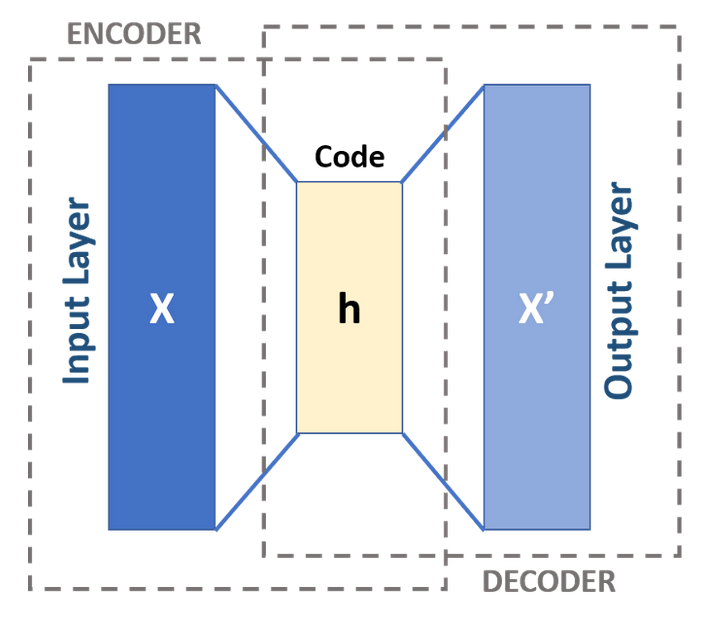
-Imagem retirada de https://en.wikipedia.org/wiki/Autoencoder#/media/File:Autoencoder_schema.png

O encoder reduz a dimensionalidade dos dados para sua representação comprimida, já o decoder é a parte da rede que descomprime os dados para sua forma original - porém, com perda de informação.

A rede neural faz isso aprendendo a forma dos dados através de suas correlações. As primeiras camadas da rede aprendem as características mais globais da curva e camadas mais interiores capturam suas nuances. O auto-encoder é treinado para um tipo específico de dados, sendo assim, um auto-encoder de redshift fotométrico faria um péssimo trabalho comprimindo e descomprimindo outros tipos de dados. 

In [4]:
#função para plotar gráficos que será utilizada posteriormente
def plot_compare(data, decomp, sigma = False, label_data = 'Original', label_decomp = 'Reconstructed'):
    if sigma:
        ver=2
        hor=2

        fig = plt.figure(figsize=(12, 6), constrained_layout=True)
        gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

        k=0
        for v in range(ver):
            for h in range(hor):
                idx = random.sample(range(data.shape[0]), 1)[0]
                ax = fig.add_subplot(gs[v, h])

                ax.plot(bins, data[idx].squeeze(),'--',  alpha=1, 
                        label="$\sigma_{original} = $ "+str(round(np.sqrt(data[idx].var(ddof=1)),3)))
                ax.plot(bins, decomp[idx].squeeze(),'-', alpha=0.5, 
                        label="$\sigma_{reconstructed} = $ "+str(round(np.sqrt(decomp[idx].var(ddof=1)),3)))

                ax.set_title("$Z_{photo}$ = "+str(round(np.average(bins, weights = data[idx]),3)))
                plt.legend(loc='best')
                k+=1
    else:
        ver=2
        hor=2

        fig = plt.figure(figsize=(12, 6), constrained_layout=True)
        gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

        k=0
        for v in range(ver):
            for h in range(hor):
                idx = random.sample(range(data.shape[0]), 1)[0]
                ax = fig.add_subplot(gs[v, h])

                ax.plot(bins, data[idx].squeeze(),'--',  alpha=1, 
                        label=label_data)
                ax.plot(bins, decomp[idx].squeeze(),'-', alpha=0.5, 
                        label=label_decomp)

                ax.set_title("$Z_{photo}$ = "+str(round(np.average(bins, weights = data[idx]),3)))
                if k==0: plt.legend(loc='best')
                k+=1

Antes de passar nossos dados para o auto-encoder vamos tratá-los. Eles devem possuir média 0 e variância 1.

In [5]:
data = zpdfs

# Aqui escalamos os dados para que possuam média 0 e variância 1, isso facilitará o processo de compressão
scaler = StandardScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)

Abaixo construímos a arquitetura de nosso auto-encoder:

In [13]:
# Dimensão do espaço original
input_dim = 200

# Dimensão do espaço latente (espaço comprimido)
latent_dim = 20

encoder = Sequential([
    Dense(100, activation='linear', input_shape=(input_dim,)),
#     Dense(50, activation='linear'),
    Dense(latent_dim, activation='relu')
#     Dense(latent_dim, activation='relu', input_shape=(input_dim,))
])

decoder = Sequential([
    Dense(100, activation='relu', input_shape=(latent_dim,)),
#     Dense(50, activation ='linear'),
    Dense(input_dim, activation='linear')
#     Dense(input_dim, activation='relu', input_shape=(latent_dim,))
])

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

Agora vamos treinar o auto-encoder. Este processo já foi feito, caso não queira que ele seja repetido, basta pular para a próxima célula e colocar a opção load_model = True.

Epoch 1/200
409/409 [==============================] - 1s 2ms/step - loss: 0.0883
Epoch 2/200
409/409 [==============================] - 1s 2ms/step - loss: 0.0042A: 0s - loss: 0.00
Epoch 3/200
409/409 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 4/200
409/409 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 5/200
409/409 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 6/200
409/409 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/200
409/409 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 8/200
409/409 [==============================] - 1s 2ms/step - loss: 9.6755e-04
Epoch 9/200
409/409 [==============================] - 1s 2ms/step - loss: 8.6700e-04
Epoch 10/200
409/409 [==============================] - 1s 3ms/step - loss: 8.4494e-04
Epoch 11/200
409/409 [==============================] - 2s 4ms/step - loss: 7.1637e-04
Epoch 12/200
409/409 [==============================] - 1s 3ms

409/409 [==============================] - 1s 2ms/step - loss: 1.0758e-04
Epoch 185/200
409/409 [==============================] - 1s 2ms/step - loss: 1.5718e-04
Epoch 186/200
409/409 [==============================] - 1s 2ms/step - loss: 1.3512e-04
Epoch 187/200
409/409 [==============================] - 1s 2ms/step - loss: 1.3515e-04
Epoch 188/200
409/409 [==============================] - 1s 2ms/step - loss: 1.3146e-04
Epoch 189/200
409/409 [==============================] - 1s 2ms/step - loss: 1.5721e-04
Epoch 190/200
409/409 [==============================] - 1s 2ms/step - loss: 1.9719e-04
Epoch 191/200
409/409 [==============================] - 1s 2ms/step - loss: 8.4753e-05
Epoch 192/200
409/409 [==============================] - 1s 2ms/step - loss: 1.2775e-04
Epoch 193/200
409/409 [==============================] - 1s 2ms/step - loss: 2.1989e-04
Epoch 194/200
409/409 [==============================] - 1s 2ms/step - loss: 8.8909e-05
Epoch 195/200
409/409 [=======================

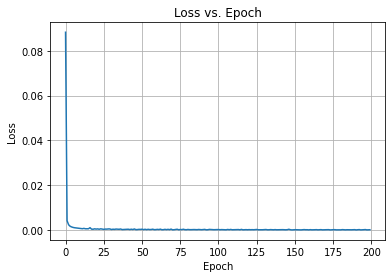

In [14]:
# Caso não queira treinar a rede passe para o próximo passo onde importamos os resultados!

save_model = False
model_history = autoencoder.fit(data_scaled, data_scaled, epochs=200, batch_size=50) #, verbose=0)

if save_model:
    #Salvando modelo
    autoencoder.save("autoencoder.h5")
    print("Salvando modelo no disco")
    #Salvando os dados comprimidos  
    df_save = pd.DataFrame(encoder.predict(data_scaled))
    df_save.to_csv('encoder_compressed.csv')
    print("Salvando dados no disco")



#plotando a loss
plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

In [8]:
#Carregando modelo do disco:
load_model = False #True para importar modelo
if load_model:
    autoencoder = keras.models.load_model('autoencoder.h5')
    autoencoder.summary()

Agora vamos visualizar uma comparação entre os dados comprimidos e os dados reconstruídos:

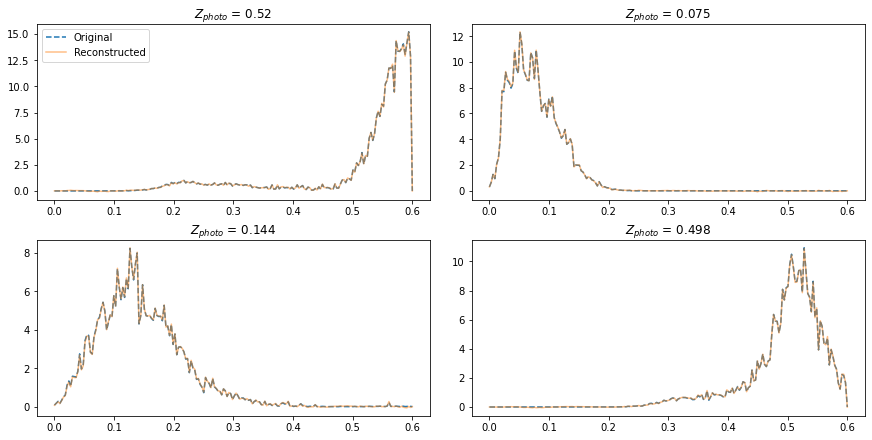

In [9]:
compressed = encoder.predict(data_scaled) #temos que usar os dados em escala
decompressed = decoder.predict(compressed)

data = zpdfs
decomp = scaler.inverse_transform(decompressed)
plot_compare(data,decomp)

Os dados comprimidos possuem 3 Mb, junto com o arquivo do auto-encoder, necessário para comprimir e descomprimir os dados, temos 3558 Kb. Comparando com o tamanho do arquivo original, de 57483 Kb, temos uma compressão com $6.2\%$ do tamanho dos dados originais. 

## PCA ou auto-encoder ?

Vamos comparar a qualidade de compressão de PCA e auto-encoder, para isso utilizaremos dois critérios:

1. Divergência de Kullback-Leibler
2. Critério de informação Bayesiana

In [15]:
def kbl_divergence(p, q, x):
    '''
    Implements the Kullback-Leibler divergence D(p|q);
    Parameters:
    np.array, p    :   N-dimensional array containing the PDF p(x)      
    np.array, q    :   N-dimensional array containing the PDF q(x) 
    np.array, x    :   N-dimensional array containing the x values os p and q.     

    Returns de Kullback-Leibler divergence D(p|q)

    Dependencies: numpy
    '''
    dx=x[1]-x[0]
    
    pnz = np.where(p>0, p, 1e-20)
    qnz = np.where(q>0, q, 1e-20)
    
    return (np.sum(pnz*np.log(pnz))-np.sum(pnz*np.log(qnz)))*dx

#implementando a função p/ calcular o BIC
def bic(k,n,L): 
    return k*np.log(n)-2*np.log(L)

In [20]:
PDF = zpdfs
# Aqui escalamos os dados para que possuam média 0 e variância 1
scaler = StandardScaler()
scaler.fit(PDF)
data_scaled = scaler.transform(PDF)

#Carregando auto-encoder do disco:
autoencoder = keras.models.load_model('autoencoder.h5')
encoder_compressed = encoder.predict(data_scaled)
encoder_decompressed = scaler.inverse_transform(autoencoder.predict(data_scaled))
autoencoder.summary()

pca=PCA(n_components=50)
pca_compressed=pca.fit_transform(PDF)
pca_decompressed=pca.inverse_transform(pca_compressed)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
sequential_1 (Sequential)    (None, 200)               22300     
Total params: 44,420
Trainable params: 44,420
Non-trainable params: 0
_________________________________________________________________


BIC relativo PCA:  1e-05 %
BIC relativo encoder:  8e-05 %
Dkbl_pca 	 |	 Dkbl_encoder
104.583 	 | 	 1176.53


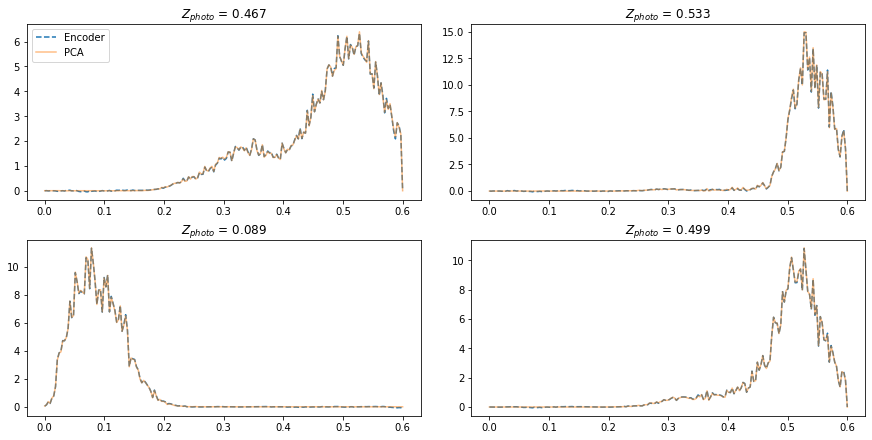

In [21]:
#Parâmetros para a função bic(args_)
nori, kori = np.shape(PDF)
npca, kpca = np.shape(pca_decompressed)
nenc, kenc = np.shape(encoder_decompressed)

#Somatório do máximo das likelihoods, aqui interpretadas como posteriori, na ausência de informação a priori.
Lori = np.sum(list(map(max,PDF)))
Lpca = np.sum(list(map(max,pca_decompressed)))
Lenc = np.sum(list(map(max,encoder_decompressed)))

#BIC dos dados após a descompressão
bic_pca = bic(kpca,npca,Lpca)  
bic_ori = bic(kori,nori,Lori)
bic_encoder = bic(kenc,nenc,Lenc)

#entropia relativa com relação aos dados originais:
kbl_pca = kbl_divergence(pca_decompressed, PDF, bins)
kbl_encoder = kbl_divergence(encoder_decompressed, PDF, bins)


print('BIC relativo PCA: ', round(100*(bic_pca-bic_ori)/bic_ori,5),'%')
print('BIC relativo encoder: ', round(100*(bic_ori-bic_encoder)/bic_ori,5),'%')

print("Dkbl_pca", "\t |\t", "Dkbl_encoder")
print(round(kbl_pca,3),'\t | \t',round(kbl_encoder,3))

plot_compare(encoder_decompressed,pca_decompressed, label_data='Encoder', label_decomp = 'PCA')

Como comparação, veja que os dados comprimidos pelo auto-encoder possuem uma entropia relativa com os dados menor que a compressão feita pelo PCA, o que indica uma melhor qualidade de ajuste. Além disso, no teste BIC, vemos que o BIC relativo do auto-encoder é menor que o BIC relativo para o PCA, indicando que de fato, o auto-encoder é uma ferramenta melhor para comprimir os dados.

Por fim, podemos comparar também o tamanho dos arquivos comprimidos, juntamente com os arquivos necessários para a descompressão:

> Original: 57483 Kb

> Auto-encoder: 3000+558 Kb = 3558 Kb

> PCA: 7855+34 Kb = 7889 Kb

Ou seja, aelém de comprimir mais os dados, quando utilizamos a mesma dimensão no espaço latente, o auto-encoder apresenta uma melhor qualidade de compressão, quando analisamos o BIC e a entropia relativa entre os dados reconstruídos e os dados originais.